<a href="https://colab.research.google.com/github/chaiminwoo0223/Deep-Learning/blob/main/08%20-%20CNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

2.0.0+cu118


# 하이퍼파라미터

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

# 데이터

## 1.데이터 다운로드

In [3]:
mnist_train = dset.MNIST(root="../", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root="../", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [4]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000


In [5]:
print(len(mnist_train))
print(len(mnist_test))

60000
10000


## 2.DataLoader
- 사용할 데이터
- 배치 사이즈 (batch_size)
- 섞을지 여부 (shuffle)
- 사용할 프로세스 개수 (num_workers)
- 마지막에 남는 데이터의 처리 여부 (drop_last)

In [6]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# CNN

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),  # [batch_size,1,28,28] -> [batch_size,16,24,24]
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # [batch_size,16,24,24] -> [batch_size,32,20,20]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     # [batch_size,32,20,20] -> [batch_size,32,10,10]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # [batch_size,32,10,10] -> [batch_size,64,6,6]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                      # [batch_size,64,6,6] -> [batch_size,64,3,3]
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3, 100),                                    # [batch_size,64*3*3] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100,10)                                          # [batch_size,100] -> [batch_size,10]
        )
    def forward(self,x):
        out = self.layer(x)                                            # [batch_size,64,3,3]
        out = out.view(batch_size, -1)                                 # [batch_size,64*3*3]
        out = self.fc_layer(out)                                       # [batch_size,10]
        return out

In [8]:
if torch.cuda.is_available(): 
    device = torch.device('cuda:0') # GPU가 사용 가능한 경우에는 device를 GPU로 설정
else:
    device = torch.device('cpu')    # GPU가 사용 불가능한 경우에는 device를 CPU로 설정
print(device)

cuda:0


In [9]:
# 모델을 지정한 장치로 올림
model = CNN().to(device)

In [10]:
# 손실함수
loss_func = nn.CrossEntropyLoss()
# 최적화함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 훈련

In [11]:
loss_arr = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2790, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1437, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1518, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1453, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0193, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0265, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0373, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0580, device='cuda:0', grad_fn=<NllLossBackward0>)


## 손실 시각화

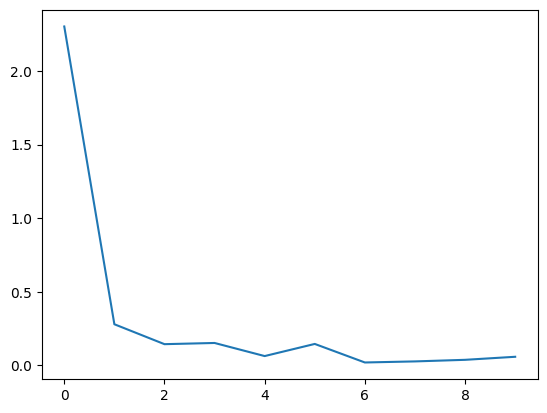

In [12]:
plt.plot(loss_arr)
plt.show()

# 테스트 데이터의 정확도 측정

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for image, label in test_loader:
        x = image.to(device)
        y_= label.to(device)

        output = model.forward(x)
        _, output_index = torch.max(output,1)
        total += label.size(0)
        correct += (output_index == y_).sum().float()

    print("Accuracy of Test Data : {}%".format(100*correct/total))

Accuracy of Test Data : 98.93830108642578%
